In [ ]:
from tensorflow.keras.layers import Dense, Input, Conv2D
from tensorflow.keras.models import Model
#create a model containing two conv2d layer
inputs = Input(shape=(28,28,1))
x = Conv2D(16, (3,3), activation='relu')(inputs)
x = Conv2D(128, (3,3), activation='relu')(x)
model = Model(inputs=inputs, outputs=x)
model.summary()


In [ ]:
from qkeras import QBidirectional, QGRU
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Model

# define model
input = Input((70,73))
x = QBidirectional(
        layer = QGRU(16, 
                        time_major=False,
                        kernel_quantizer="quantized_bits(8,0,0,alpha=1)", 
                        recurrent_quantizer="quantized_bits(8,0,0,alpha=1)", 
                        bias_quantizer="quantized_bits(8,0,0,alpha=1)", 
                        state_quantizer="quantized_bits(8,0,0,alpha=1)",
                        activation="quantized_tanh(8)",
                        recurrent_activation="quantized_sigmoid(8)",
                        reset_after=True),
        backward_layer = QGRU(16, 
                        time_major=False,
                        go_backwards=True,
                        kernel_quantizer="quantized_bits(8,0,0,alpha=1)", 
                        recurrent_quantizer="quantized_bits(8,0,0,alpha=1)", 
                        bias_quantizer="quantized_bits(8,0,0,alpha=1)", 
                        state_quantizer="quantized_bits(8,0,0,alpha=1)",
                        activation="quantized_tanh(8)",
                        recurrent_activation="quantized_sigmoid(8)",
                        reset_after=True))(input)
model = Model(inputs=input, outputs=x)
model.summary()

from qbidirectional import HQBidirectional, parse_qbidirectional_layer, BidirectionalConfigTemplate, BidirectionalFunctionTemplate
from qgru import HQGRU, parse_qgru_layer, QGRUConfigTemplate, QGRUFunctionTemplate
import hls4ml
#register parser
hls4ml.converters.register_keras_layer_handler('QBidirectional', parse_qbidirectional_layer)
hls4ml.converters.register_keras_layer_handler('QGRU', parse_qgru_layer)
#register hls layer
hls4ml.model.layers.register_layer('QBidirectional', HQBidirectional)
hls4ml.model.layers.register_layer('QGRU', HQGRU)
#register hls template
for backend_id in ['Vivado', 'Quartus', 'VivadoAccelerator']:
    # Register the optimization passes (if any)
    backend = hls4ml.backends.get_backend(backend_id)
    #backend.register_pass('remove_duplicate_reverse', RemoveDuplicateReverse, flow=f'{backend_id.lower()}:optimize')

    # Register template passes for the given backend
    backend.register_template(BidirectionalConfigTemplate)
    backend.register_template(BidirectionalFunctionTemplate)
    backend.register_template(QGRUConfigTemplate)
    backend.register_template(QGRUFunctionTemplate)

    # Register HLS implementation
    backend.register_source('/home/hisky/lfads_impl/nnet_bidirectional.h')

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

x = Input(shape=(32))
y = DotProduct(32)(x)
model = Model(inputs=x, outputs=y)
model.summary()

from hls4ml.model.flow.flow import flow_map
from pprint import pprint
from hls4ml.model.optimizer import optimize_model
from hls4ml.model.optimizer.optimizer import optimizer_map
pprint(optimizer_map)
pprint(flow_map['vivado:write'].optimizers)

In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Flatten, GRU, Activation, Embedding, Bidirectional 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import Model
import tensorflow as tf
initializer = tf.keras.initializers.VarianceScaling(distribution='normal')
regularizer = tf.keras.regularizers.L2(l=1)
#inputs2model = neural_data # 136, 73, 70
inputDim = 136
#inputs2decoder = tf.stack([tf.zeros_like(inputs2model)[:, :, -1]
            #for i in range(64)], axis=-1)
# inputs2decoder = np.zeros((17,73,64))
def create_model(initializer, regularizer):
  
  inputLayer =  Input(shape=(73,70))
  #x = Dropout(0.05, name = 'initial_dropout')(inputLayer)
  x = QBidirectional(
        layer = QGRU(64, 
                        time_major=False,
                        kernel_quantizer="quantized_bits(8,0,0,alpha=1)", 
                        recurrent_quantizer="quantized_bits(8,0,0,alpha=1)", 
                        bias_quantizer="quantized_bits(8,0,0,alpha=1)", 
                        state_quantizer="quantized_bits(8,0,0,alpha=1)",
                        activation="quantized_tanh(8)",
                        recurrent_activation="quantized_sigmoid(8)",
                        reset_after=True),
        backward_layer = QGRU(64, 
                        time_major=False,
                        go_backwards=True,
                        kernel_quantizer="quantized_bits(8,0,0,alpha=1)", 
                        recurrent_quantizer="quantized_bits(8,0,0,alpha=1)", 
                        bias_quantizer="quantized_bits(8,0,0,alpha=1)", 
                        state_quantizer="quantized_bits(8,0,0,alpha=1)",
                        activation="quantized_tanh(8)",
                        recurrent_activation="quantized_sigmoid(8)",
                        reset_after=True))(inputLayer)
  #x = Dropout(0.05, name = 'postencoder_dropout')(x)
  x = Dense(64, kernel_regularizer=regularizer, kernel_initializer=initializer, name='dense_mean')(x)
  input_decoder = Input(shape=(73,64))
  x = QGRU(64, 
                        time_major=False,
                        go_backwards=True,
                        kernel_quantizer="quantized_bits(8,0,0,alpha=1)", 
                        recurrent_quantizer="quantized_bits(8,0,0,alpha=1)", 
                        bias_quantizer="quantized_bits(8,0,0,alpha=1)", 
                        state_quantizer="quantized_bits(8,0,0,alpha=1)",
                        activation="quantized_tanh(8)",
                        recurrent_activation="quantized_sigmoid(8)",
                        reset_after=True)(input_decoder, initial_state = x)
  #x = Dropout(0.05, name = 'postdecoder_dropout')(x)
  z = Dense(4, use_bias = False, kernel_regularizer=regularizer, kernel_initializer=initializer, name='dense')(x)
  log_f = Dense(70, kernel_regularizer=regularizer, kernel_initializer=initializer, name='nerual_dense')(z)
  return Model(inputs = [inputLayer,input_decoder], outputs =[z, log_f])

model = create_model(initializer, regularizer)
model.summary()

In [1]:
from qkeras import QBidirectional, QGRU, QDense, QActivation
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.models import Model
def create_model(act_total_bits=8, act_int_bits=2, 
                 qgru_total_bits=8, qgru_int_bits=2, qgru_sigmoid_bits=8, qgru_tanh_bits=8, drop=0.05
                ):
    
    # keras tuner params:
    
    act_quan = "quantized_bits({},{},alpha=1)".format(act_total_bits, act_int_bits)
    quan = "quantized_bits({},{},alpha=1)".format(qgru_total_bits, qgru_int_bits)
    q_sigmoid = "quantized_sigmoid({})".format(qgru_sigmoid_bits)
    q_tanh = "quantized_tanh({})".format(qgru_tanh_bits)
       
    # input layer
    inputLayer =  Input(shape=(73,70))  #73,70  
    # no need to quantize the input layer, already qunaitzed  

    x = Dropout(drop, name = 'initial_dropout')(inputLayer)
    
    # encoder
    forward_layer = QGRU(
            64, 
            activation=q_tanh,
            recurrent_activation=q_sigmoid,
            kernel_quantizer=quan,
            recurrent_quantizer=quan,
            bias_quantizer=quan,
            state_quantizer=act_quan,
            reset_after = True,
           time_major=False, name="EncoderGRUForward")
    
    backward_layer = QGRU(
            64, 
            activation=q_tanh,
            recurrent_activation=q_sigmoid,
            kernel_quantizer=quan,
            recurrent_quantizer=quan,
            bias_quantizer=quan,
            state_quantizer=act_quan,
            reset_after = True,
            time_major=False, name="EncoderGRUBackward", go_backwards=True)
        
        
    x = QBidirectional(
        forward_layer, 
        backward_layer=backward_layer,
        merge_mode='concat', 
        name = 'Encoder_BidirectionalGRU'
        )(x)    
    x = QActivation(act_quan, name = "active_bits0")(x)
    
    x = Dropout(drop, name = 'postencoder_dropout')(x)
    
    # latent space, no mean and var 
    x = QDense(64, 
               kernel_quantizer=quan,
               bias_quantizer=quan,
               name='dense_latent'
              )(x)
    x = QActivation(act_quan, name = "active_bits1")(x)

    # decoder
    input_decoder = Input(shape=(73, 64))
    x = QGRU(                        
            64, 
            activation=q_tanh,
            recurrent_activation=q_sigmoid,
            kernel_quantizer=quan,
            recurrent_quantizer=quan,
            bias_quantizer=quan,
            state_quantizer=act_quan,
            reset_after = True,
            time_major=False, name='DecoderGRU'
    )(input_decoder, initial_state = x)

    x = QActivation(act_quan, name = "active_bits2")(x)
    
    x = Dropout(drop, name = 'postdecoder_dropout')(x)
    z = QDense(4, 
            kernel_quantizer=quan,
            bias_quantizer=quan,
            use_bias=False, 
            name="dense"
            )(x)
    z = QActivation(act_quan, name = "active_bits3")(z)
    
    log_f = QDense(70, 
            kernel_quantizer=quan,
            bias_quantizer=quan,
            use_bias=False, 
            name='nerual_dense')(z)
    
    z = QActivation(act_quan, name = "active_bits4")(log_f)

    model = Model(inputs = [inputLayer,input_decoder], outputs =x)
    
    return model

model = create_model(   act_total_bits=8, 
                        act_int_bits=0, 
                        qgru_total_bits=8, 
                        qgru_int_bits=0, 
                        qgru_sigmoid_bits=8, 
                        qgru_tanh_bits=8, 
                        drop=0.05
                    )
model.summary()

2023-08-16 22:11:18.523794: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-16 22:11:18.523824: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-16 22:11:19.760677: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-08-16 22:11:19.760862: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-08-16 22:11:19.760875: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-16 22:11:19.760904: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 73, 70)]     0                                            
__________________________________________________________________________________________________
initial_dropout (Dropout)       (None, 73, 70)       0           input_1[0][0]                    
__________________________________________________________________________________________________
Encoder_BidirectionalGRU (QBidi (None, 128)          52224       initial_dropout[0][0]            
__________________________________________________________________________________________________
active_bits0 (QActivation)      (None, 128)          0           Encoder_BidirectionalGRU[0][0]   
______________________________________________________________________________________________

In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Flatten, GRU, Activation, Embedding, Bidirectional 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import Model
from qkeras import QDense, QActivation, QGRU
import tensorflow as tf
input_decoder = Input(shape=(73, 64))
input2 = Input(shape=(64,))    
x = GRU(                        
        64, 
        #activation="quantized_tanh(8)",
        #recurrent_activation="quantized_sigmoid(8)",
        #kernel_quantizer="quantized_bits(8,0,0,alpha=1)",
        #recurrent_quantizer="quantized_bits(8,0,0,alpha=1)",
        #bias_quantizer="quantized_bits(8,0,0,alpha=1)",
        #state_quantizer="quantized_bits(8,0,0,alpha=1)",
        reset_after = True,
        name='DecoderGRU'
)(input_decoder)
model = Model(inputs=input_decoder, outputs=x)
model.summary()

In [2]:
import hls4ml
#hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
#hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND_CONV'
#hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'
config = hls4ml.utils.config_from_keras_model(model, granularity='name', default_precision='ap_fixed<32,16>')
import pprint
pprint.pprint(config)
for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Trace'] = True 
config['LayerName']['DecoderGRU']['Strategy'] = 'Resource' 
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir='./hls_model/lfads_model',
                                                       io_type = 'io_parallel',
                                                       #backend='VivadoAccelerator', board='pynq-z2')
                                                       part='xc7z020clg400-1')
hls_model.compile()

/home/hisky/anaconda3/envs/lfads_hls4ml_new/lib/python3.8/site-packages/hls4ml-0.0.0-py3.8.egg/hls4ml/converters/__init__.py:24: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


Interpreting Model
Topology:
{'name': 'input_1', 'class_name': 'InputLayer', 'data_format': 'channels_last', 'input_shape': [73, 70]}
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 73, 70]], output shape: [None, 73, 70]
{'name': 'Encoder_BidirectionalGRU', 'class_name': 'QBidirectional', 'inputs': ['input_1'], 'data_format': 'channels_last', 'activation': 'hard_tanh', 'use_bias': True, 'return_sequences': False, 'return_state': False, 'recurrent_activation': 'hard_sigmoid', 'time_major': False, 'n_timesteps': 73, 'n_in': 70, 'n_out': 128, 'initial_state': 0, 'recurrent_activation_quantizer': {'class_name': 'quantized_sigmoid', 'config': {'bits': 8, 'symmetric': False, 'use_real_sigmoid': False, 'use_stochastic_rounding': False}}, 'activation_quantizer': {'class_name': 'quantized_tanh', 'config': {'bits': 8, 'symmetric': False, 'use_stochastic_rounding': False, 'use_real_tanh': False}}, 'state_quantizer': <hls4ml.model.types.QKerasQuantizer object at 0x7fa4e80feee0>,

import numpy as np
rd_arr = np.random.rand(1,70,73)
from qkeras.quantizers import quantized_bits
#qtz = quantized_bits(8,0,0)
#rd_arr = np.array(qtz(rd_arr))
print(rd_arr)
print('model predict: ', model.predict(rd_arr))
print('hls4ml predict: ', hls_model.predict(rd_arr))
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(hls_model.predict(rd_arr), model.predict(rd_arr).flatten()))

In [3]:
import numpy as np
x0 = np.random.rand(1, 73, 70)
x1 = np.random.rand(1, 73, 64)
#x1 = np.zeros((1, 64))
from qkeras.quantizers import quantized_bits
qtz = quantized_bits(8,0,0)
x0 = np.array(qtz(x0))
x1 = np.array(qtz(x1))
print(hls_model.predict([x0,x1]))
print(model.predict([x0,x1]))
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(hls_model.predict([x0,x1]), model.predict([x0,x1]).flatten()))
#np.savetxt('./hls_model/dotproduct/tb_data/tb_input_features.dat', x.reshape(1,-1))
#np.savetxt('./hls_model/dotproduct/tb_data/tb_output_predictions.dat', model.predict(x).reshape(1,-1))

[ 0.0546875  0.6171875 -0.4453125 -0.0390625 -0.734375   0.5390625
  0.375      0.1171875 -0.2578125  0.140625  -0.0859375  0.1328125
 -0.1953125  0.5625    -0.1796875 -0.140625  -0.3984375 -0.2734375
  0.6953125 -0.15625   -0.1484375  0.71875   -0.0078125 -0.25
 -0.0859375 -0.6875    -0.421875  -0.234375  -0.625      0.9140625
 -0.234375   0.1640625  0.2109375 -0.21875    0.2734375 -0.2890625
 -0.0546875  0.78125   -0.4296875  0.2421875  0.265625   0.1015625
  0.0234375  0.140625  -0.265625   0.1796875 -0.0703125 -0.1328125
  0.1640625  0.1171875 -0.3828125 -0.1328125  0.59375   -0.015625
 -0.2265625  0.2578125  0.046875  -0.2734375 -0.0546875 -0.03125
  0.40625   -0.484375   0.3046875  0.734375 ]


2023-08-16 22:12:11.054143: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-08-16 22:12:11.054622: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3194030000 Hz


[[ 0.0546875  0.6171875 -0.4453125 -0.0390625 -0.734375   0.5390625
   0.3828125  0.1171875 -0.2578125  0.140625  -0.0859375  0.1328125
  -0.1953125  0.5625    -0.1796875 -0.140625  -0.3984375 -0.2734375
   0.6953125 -0.15625   -0.1484375  0.71875   -0.0078125 -0.25
  -0.078125  -0.6796875 -0.4140625 -0.234375  -0.6328125  0.9140625
  -0.2421875  0.1640625  0.2109375 -0.21875    0.28125   -0.2890625
  -0.0546875  0.78125   -0.4296875  0.2421875  0.2734375  0.1015625
   0.0234375  0.140625  -0.265625   0.1796875 -0.0703125 -0.1328125
   0.1640625  0.1171875 -0.390625  -0.1328125  0.59375   -0.015625
  -0.2265625  0.2578125  0.046875  -0.2734375 -0.0546875 -0.03125
   0.40625   -0.484375   0.3046875  0.734375 ]]
0.0010986328


In [ ]:
hls4ml.model.profiling.numerical(model=model, hls_model=hls_model, X=[x0, x1])

Processing input_1 in Keras model...
Processing initial_dropout in Keras model...
Processing Encoder_BidirectionalGRU in Keras model...
Processing active_bits0 in Keras model...
Processing postencoder_dropout in Keras model...
Processing dense_latent in Keras model...
Processing input_2 in Keras model...
Processing active_bits1 in Keras model...
Processing DecoderGRU in Keras model...
Processing active_bits2 in Keras model...
Processing postdecoder_dropout in Keras model...
Done taking outputs for Keras model.
Recompiling myproject with tracing
Writing HLS project
Done
Plotting difference...
------------
[1 2 3 4 5 6]
[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

/home/hisky/anaconda3/envs/lfads_hls4ml_new/lib/python3.8/site-packages/hls4ml-0.0.0-py3.8.egg/hls4ml/model/profiling.py:641: RuntimeWarning: invalid value encountered in true_divide
  diff[key] = np.absolute(flattened_ymodel - flattened_ysim) / np.linalg.norm(flattened_ymodel - flattened_ysim)


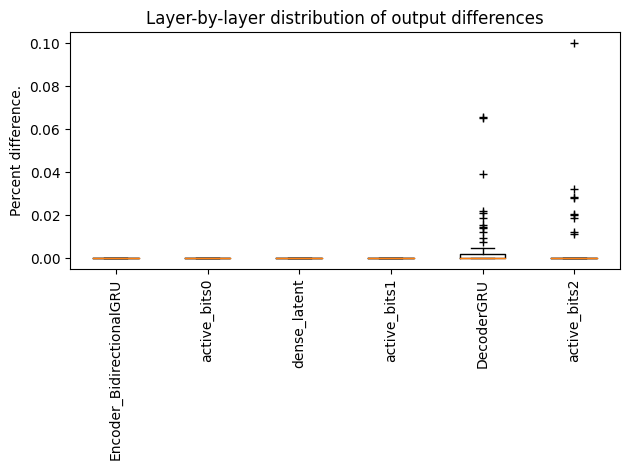

<Figure size 640x480 with 0 Axes>

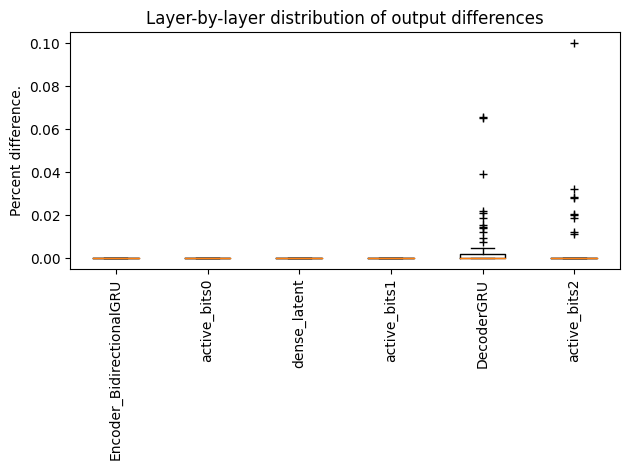

In [4]:
hls4ml.model.profiling.compare(keras_model=model, hls_model=hls_model, X=[x0, x1])

In [ ]:
!source /opt/Xilinx/Vivado/2019.2/settings64.sh
import os
os.environ['PATH'] = '/opt/Xilinx/Vivado/2019.2' + '/bin:' + os.environ['PATH']
hls_model.build(csim=True, synth=True, vsynth=True, cosim=True, validation=True, export=True)

In [ ]:
hls4ml.report.parse_vivado_report('/home/hisky/Lab-undergrad/Lab4/hls_model/dotproduct')

In [ ]:
import hls4ml
#hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
#hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND_CONV'
#hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'
config = hls4ml.utils.config_from_keras_model(model, granularity='name', default_precision='ap_fixed<32,16>')
import pprint
pprint.pprint(config)  
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir='./hls_model/dotproduct_axi',
                                                       io_type = 'io_stream',
                                                       backend='VivadoAccelerator', board='pynq-z2')
                                                       #part='xc7z020clg400-1')
hls_model.compile()

In [ ]:
hls_model.build(csim=True, synth=True, vsynth=True, cosim=True, validation=True, export=True, bitfile=True)

In [ ]:
import numpy as np
np.random.seed(0)
x = np.random.rand(1, 32)
y_hls = hls_model.predict(x)
y_k = model.predict(x)
print(y_hls)
print(y_k)
np.savetxt('./hls_model/dotproduct_axi/tb_data/tb_input_features.dat', x.reshape(1,-1))
np.save('./hls_model/dotproduct_axi/tb_data/x_test.npy', x)
np.save('./hls_model/dotproduct_axi/tb_data/y_hls.npy', y_hls)
np.save('./hls_model/dotproduct_axi/tb_data/y_k.npy', y_k)
np.savetxt('./hls_model/dotproduct_axi/tb_data/tb_output_predictions.dat', model.predict(x).reshape(1,-1))

In [5]:
from tensorflow.keras.models  import load_model
from qkeras.utils import _add_supported_quantized_objects   
co = {}
_add_supported_quantized_objects(co)
model = load_model('lfad4bitssgd_qweights.h5', custom_objects=co, compile=False)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 73, 70)]     0                                            
__________________________________________________________________________________________________
initial_dropout (Dropout)       (None, 73, 70)       0           input_1[0][0]                    
__________________________________________________________________________________________________
Encoder_BidirectionalGRU (Bidir [(None, 128), (None, 52224       initial_dropout[0][0]            
__________________________________________________________________________________________________
q_act_postencoder (QActivation) (None, 128)          0           Encoder_BidirectionalGRU[0][0]   
______________________________________________________________________________________________